In [1]:
import shap
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# nonstationary forcing 
input_data = np.load('data/input_sal_temp_ns.npy')
output_data = np.load('data/output_sal_temp_ns.npy')

In [3]:
X_train = input_data[0:75000]
y_train = output_data[0:75000]
X_val = input_data[75000:90000]
y_val = output_data[75000:90000]
X_test = input_data[90000:100000]
y_test = output_data[90000:100000] 

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_,scaler.scale_

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

Y_train = keras.utils.to_categorical(y_train)
Y_val = keras.utils.to_categorical(y_val)
Y_test = keras.utils.to_categorical(y_test)
output_scaled = keras.utils.to_categorical(output_data)

In [10]:
# sequences to input into LSTM 
def create_sequences(input_data, output_data, time_steps):
    input_sequences, output_sequences = [], []
    for i in range(len(input_data) - time_steps + 1):
        input_sequences.append(input_data[i:i + time_steps])
        output_sequences.append(output_data[i + time_steps - 1]) 
    return np.array(input_sequences), np.array(output_sequences)

time_steps = 10
feature_dim = 5

X_train_seq, y_train_seq = create_sequences(X_train_scaled, Y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, Y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, Y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_scaled, time_steps)

print("Input shape:", X_val_seq.shape)  
print("Output shape:", y_train_seq.shape) 


Input shape: (14991, 10, 5)
Output shape: (74991, 2)


In [11]:
train_sample = shap.sample(X_train_seq, 100)
input_sample = shap.sample(input_seq, 100)

In [12]:
# 100 samples, 10 time steps, 5 features
train_sample.shape

(100, 10, 5)

In [13]:
# removing time feature 
train_sample_wo_time = train_sample[:, :, 1:5]
input_sample_wo_time = input_sample[:, :, 1:5]

In [14]:
model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim-1), return_sequences=False),  
    Dense(4, activation='relu'), 
    Dense(2, activation='relu'),
    Dense(2, activation='softmax')  
])

model.load_weights("lstm_wo_time.h5")

In [15]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
input_sample_wo_time.shape

(100, 10, 4)

In [17]:
input_sample_flattened = input_sample_wo_time.reshape(input_sample_wo_time.shape[0], -1)

# custom predict function for SHAP because explainer requires 2D input while model takes 3D input
def predict_flattened(X):
    X_reshaped = X.reshape(X.shape[0], time_steps, feature_dim-1)
    return model.predict(X_reshaped)

explainer = shap.KernelExplainer(predict_flattened, input_sample_flattened)

shap_values = explainer.shap_values(input_sample_flattened)


4/4 [==============================] - 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

6650/6650 [==============================] - 8s 1ms/step


6650/6650 [==============================] - 7s 1ms/step


In [123]:
shap_values = np.array(shap_values)

In [124]:
aggregated_shap = []

for i in range(0, shap_values.shape[2], 10):
    aggregated_shap.append(np.mean(shap_values[:, :, i:i+10], axis=2))

shap_values_aggregated = np.stack(aggregated_shap, axis=2)

print("Aggregated SHAP shape:", shap_values_aggregated.shape)

Aggregated SHAP shape: (2, 100, 4)


In [125]:
shap_values_aggregated[1].shape

(100, 4)

In [126]:
input_sample_wo_time.shape

(100, 10, 4)

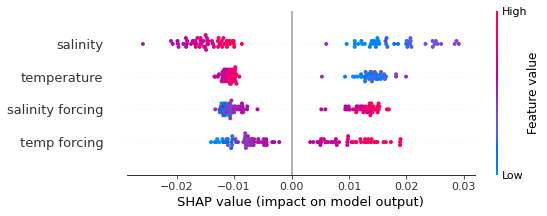

In [127]:
shap.summary_plot(shap_values_aggregated[1], input_sample_wo_time[:, 0, :], feature_names=['salinity', 'temperature', 'salinity forcing', 'temp forcing'])

In [128]:
transformed_X = scaler.inverse_transform(input_sample[:, 0, :])

In [129]:
transformed_X.shape

(100, 5)

In [130]:
qvals = []
alpha=0.2; 
beta=0.8; 
k=10e9
for x in transformed_X: 
    DeltaT = x[2]
    DeltaS = x[1]
    qvals.append(-k*(-alpha*DeltaT + beta*DeltaS))

In [131]:
k=1e9
alpha=0.2
beta=0.8

In [132]:
def get_q_color(DeltaT, DeltaS):
    q = -k*(-alpha*DeltaT + beta*DeltaS)
    if q < 0:
        return 'r'
    else:
        return 'b'

In [133]:
time_total = np.load('data/input_sal_temp_ns.npy')[:, 0]

In [138]:
shap_values_aggregated.shape

(2, 100, 4)

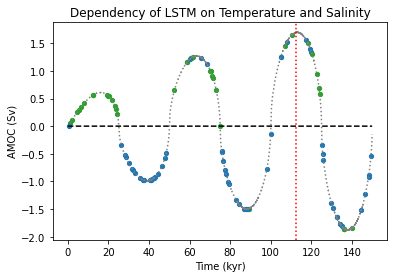

In [144]:
for i in range(100):
    # temp > salinity => green
    if shap_values_aggregated[0, i, 1] > shap_values_aggregated[0, i, 0]:
        plt.scatter(transformed_X[i, 0], -k*(-alpha*transformed_X[i, 2] + beta*transformed_X[i, 1])/1e9, marker='o', s=18, color='#2ca02c')
    else:
        plt.scatter(transformed_X[i, 0], -k*(-alpha*transformed_X[i, 2] + beta*transformed_X[i, 1])/1e9, marker='o', s=18, color='#1f77b4')

plt.xlabel('Time (kyr)');
plt.ylabel('AMOC (Sv)');
plt.title('Dependency of LSTM on Temperature and Salinity');

q = np.load('data/q_sal_temp_ns.npy')
plt.plot(time_total, q/1e10, linestyle=':', color='grey')
plt.plot(time_total, input_data[:, 0]*0, 'k--')
plt.axvline(input_data[75000][0], color='red', linestyle='dotted');

# Define custom legend labels and colors (0 corresponds to one color, 1 to another)
legend_labels = ['Temperature', 'Salinity', 'Circulation volume transport']  # Custom labels
colors = ['#2ca02c', '#1f77b4']  # Corresponding colors for the categories

# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
grey_line_handle = plt.Line2D([0], [0], linestyle=':', color='grey')
legend_handles.append(grey_line_handle)

# Add the custom legend to the plot
#plt.legend(legend_handles, legend_labels, loc='lower left');
plt.savefig('dependency_plot_lstm_ns', dpi=300)